In [1]:
import pandas as pd
import seaborn as sns
import sklearn as skl
from sklearn import linear_model
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
import re
# defaulting the image format to svg
%config InlineBackend.figure_format = "svg"

# change the pandas option to see the whole columns
pd.set_option("display.max_columns",None)

# Import data and clean data

In [2]:
df = pd.read_csv("data/samples/wine_2k_meta.csv")
# clean data
# drop unwanted column
df.drop(columns = "Unnamed: 0", inplace = True)

# renaming columns
df.rename(columns={"Alcohol":"Alcohol(%)", "Bottle Size":"Bottle Size(ml)", "Price":"Price($)"}, inplace=True)

# functions to apply in columns
def price_formatter(price):
    if str(price) == "nan" or price == None:
        pass
    else:
        return float(price.replace("$",""))

    
def alc_formatter(alc):
    if str(alc) == "nan" or alc == None:
        pass
    else:
        return float(alc.replace("%",""))
    
def bottle_size_formatter(bottle_size):
    if str(bottle_size) == "nan" or bottle_size == None:
        pass
    else:
        if "ml" in bottle_size:
            return float(bottle_size.split("ml")[0])
        elif "ML" in bottle_size:
            return float(bottle_size.split("ML")[0])
        
def appellation_formatter(app):
    return app.split(",")[-1].strip()
        
def year_formatter(wine_title):
    lists = re.compile(r"\d+").findall(wine_title)
    if len(lists) == 0:
        return None
    elif len(lists) ==1:
        return int(lists[0])
    else:
        max([int(l) for l in lists])
    
    

# Cleaning formattings of data
df["vintage"] = df["wine_name"].apply(year_formatter)
df["age"] = 2021 - df["vintage"]

df["Countries"] = df["Appellation"].apply(appellation_formatter)
df.drop(columns="Appellation", inplace=True)
df["Price($)"] = df["Price($)"].apply(price_formatter)
df["Alcohol(%)"] = df["Alcohol(%)"].apply(alc_formatter)
df["Bottle Size(ml)"] = df["Bottle Size(ml)"].apply(bottle_size_formatter)
df["User Avg Rating"] = df["User Avg Rating"].apply(lambda x: x.split(" [")[0])
df["User Avg Rating"].replace("Not rated yet", np.nan, inplace=True)


In [3]:
df.head()

,wine_name,taster,desc,rating,Price($),Designation,Variety,Winery,Alcohol(%),Bottle Size(ml),Category,Date Published,User Avg Rating,Importer,badge,vintage,age,Countries
0,McGregor 2007 Rob Roy Red Red (Finger Lakes),Anna Lee C. Iijima,"Hints of black coffee, dried lavender and herb...",85,40.0,Rob Roy Red,Bordeaux-style Red Blend,McGregor,12.7,750.0,Red,11/1/2012,NaN,NaN,NaN,2007.0,14.0,US
1,Nectar Of The Dogs 2017 3 Dogs White (Santa Ba...,Matt Kettmann,There is a pleasant tightness to the nose of t...,86,30.0,3 Dogs,White Blend,Nectar Of The Dogs,13.8,750.0,White,10/1/2020,NaN,NaN,NaN,NaN,NaN,US
2,Cantina Bergamasca 2010 Pinot Bianco (Lombardy),NaN,Here is a fresh expression of Pinot Bianco fro...,84,14.0,NaN,"Pinot Bianco, Pinot Blanc",Cantina Bergamasca,12.0,750.0,White,9/1/2011,NaN,The Harvest Importing,NaN,2010.0,11.0,Italy
3,Belvedere 2000 Chardonnay (Russian River Valley),NaN,"Rich and ripe, with fine-tuned layers of pear,...",90,20.0,NaN,Chardonnay,Belvedere,14.1,750.0,White,12/31/2002,NaN,NaN,NaN,2000.0,21.0,US
4,Jermann 2018 Sauvignon Blanc (Venezia Giulia),Kerin O’Keefe,"Racy and fragrant, this vibrant white is loade...",93,35.0,NaN,Sauvignon Blanc,Jermann,13.0,750.0,White,12/31/2019,NaN,LUX Wines,Editors' Choice,2018.0,3.0,Italy


In [4]:
feature_columns = ["Price($)","Alcohol(%)", "Bottle Size(ml)","Category","vintage","Countries","age"]
num_feats = ["Price($)","Alcohol(%)","Bottle Size(ml)","vintage","age"]
cat_feats = ["Category","Countries"]
target_feat = ["rating"]

# Extracting columns that I want to use
meta_df = df[feature_columns+target_feat]
print(meta_df.head(), meta_df.shape)

   Price($)  Alcohol(%)  Bottle Size(ml) Category  vintage Countries   age  \
0      40.0        12.7            750.0      Red   2007.0        US  14.0   
1      30.0        13.8            750.0    White      NaN        US   NaN   
2      14.0        12.0            750.0    White   2010.0     Italy  11.0   
3      20.0        14.1            750.0    White   2000.0        US  21.0   
4      35.0        13.0            750.0    White   2018.0     Italy   3.0   

   rating  
0      85  
1      86  
2      84  
3      90  
4      93   (1999, 8)


In [5]:
# getting rid of outlier to expedite the analysis 
meta_df = meta_df[meta_df["vintage"] >1000]
meta_df.reset_index(drop=True, inplace=True)
meta_df.describe()

In [8]:
# observe for missing values
meta_df.isna().sum()

Price($)           154
Alcohol(%)         254
Bottle Size(ml)      1
Category             0
vintage              0
Countries            0
age                  0
rating               0
dtype: int64

In [9]:
# Dropping all the samples with missing values
meta_df.dropna(inplace=True)
meta_df.reset_index(drop=True, inplace=True)

In [10]:
# splitting data into feature and columns then splitted into train and test set
x = meta_df[feature_columns]
y = meta_df[target_feat]
train_x, test_x, train_y, test_y  = model_selection.train_test_split(meta_df[feature_columns], meta_df["rating"], shuffle=True, random_state = 789)

In [11]:
# split train and test set by 75% and 25%
train_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)
print("shape of train data set: ", train_x.shape)
print("shape of train target: ", train_y.shape)
print("shape of test data set: ", test_x.shape)
print("shape of test target: ", test_y.shape)

shape of train data set:  (1150, 7)
shape of train target:  (1150,)
shape of test data set:  (384, 7)
shape of test target:  (384,)


# EDA

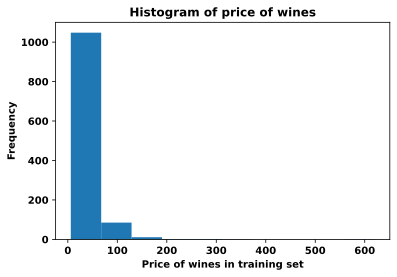

In [106]:
# histogram of columns with numerical values
plt.hist(train_x["Price($)"])
plt.xlabel("Price of wines in training set")
plt.ylabel("Frequency")
plt.title("Histogram of price of wines");

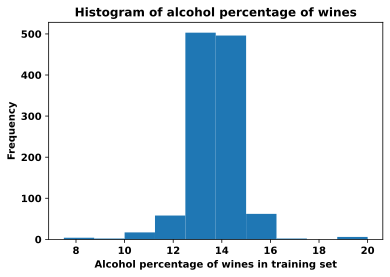

In [107]:
# histogram of columns with numerical values
plt.hist(train_x["Alcohol(%)"])
plt.xlabel("Alcohol percentage of wines in training set")
plt.ylabel("Frequency")
plt.title("Histogram of alcohol percentage of wines");

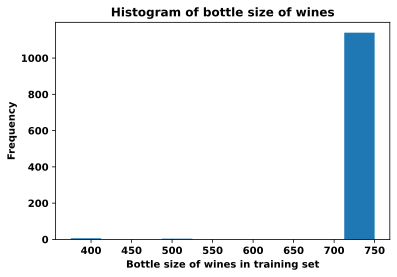

In [108]:
# histogram of columns with numerical values
plt.hist(train_x["Bottle Size(ml)"])
plt.xlabel("Bottle size of wines in training set")
plt.ylabel("Frequency")
plt.title("Histogram of bottle size of wines");

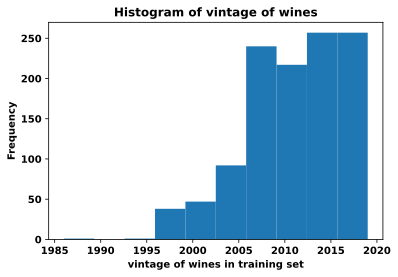

In [109]:
# histogram of columns with numerical values
plt.hist(train_x["vintage"])
plt.xlabel("vintage of wines in training set")
plt.ylabel("Frequency")
plt.title("Histogram of vintage of wines");

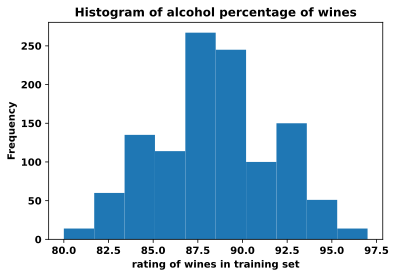

In [110]:
# histogram of columns with numerical values
plt.hist(train_y)
plt.xlabel("rating of wines in training set")
plt.ylabel("Frequency")
plt.title("Histogram of alcohol percentage of wines");

Distribution of price of wines are skewed right with most of the price concentrated around $100.

Distribution of alcohol percentage of wine is rougly normal with a small value of standard deviation, having most of the samples concentrated in it's mean value (~14%)

Distribution of the bottle size of wines skewed left very heavily, such that besides few samples, all the samples have value of 750ml.

Distribution of vintage of wine is skewed left, where the year ranges from 1971 to 2019.

Distribution of the rating is rougly normal ranging from 80 to 97.5.

In [ ]:
plt.figure(figsize=(5,5))
sns.pairplot(data = pd.concat([train_x,train_y], axis=1), x_vars = num_feats+target_feat, y_vars = num_feats+target_feat, diag_kind = "auto" ).savefig("data/numeric_pairplot.png")

# Challenge 1
### Build a linear model only using constant variable

R^2 score from training set: 0.0
R^2 score from test set: -0.0007503001962991807
Coefficient of the model for each featrues:  [0.]
Bias/Intercept of the model prediction:  88.4695652173913


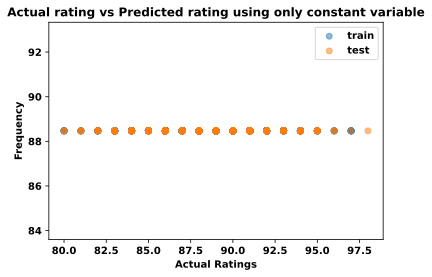

In [112]:
train_x["constant"] = [1]*len(train_x)
# Since not a transformation apply the same method for test set
test_x["constant"] = [1]*len(test_x)

train_x1 = train_x[["constant"]] 
test_x1 = test_x[["constant"]] 

lr = linear_model.LinearRegression()
lr.fit(train_x1, train_y)
print("R^2 score from training set: {}".format(lr.score(train_x1,train_y)))
print("R^2 score from test set: {}".format(lr.score(test_x1,test_y)))

print("Coefficient of the model for each featrues: ", lr.coef_)
print("Bias/Intercept of the model prediction: ", lr.intercept_)

plt.scatter(train_y, lr.predict(train_x1), label = "train", alpha = 0.5);
plt.scatter(test_y, lr.predict(test_x1), label = "test", alpha = 0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Frequency")
plt.legend()
plt.title("Actual rating vs Predicted rating using only constant variable");

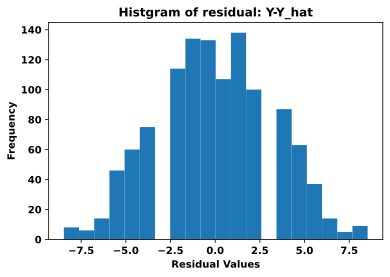

In [114]:
res = train_y - lr.predict(train_x1)
plt.hist(res, bins = 20)
plt.xlabel("Residual Values");
plt.ylabel("Frequency");
plt.title("Histgram of residual: Y-Y_hat");

The distribution of the residual calculated by Actual rating subtracted by the predicted rating has a normal distribution

# Challenge 2
### Repeat challenge 1 but with adding one continuous variable

R^2 score from training set: 0.22461501704910147
R^2 score from test set: 0.26736520751787873

Coefficient of the prediction
feature Price($) : 0.04600793507185928
feature constant : 0.0
Bias/Intercept of the model prediction:  86.87320989109797


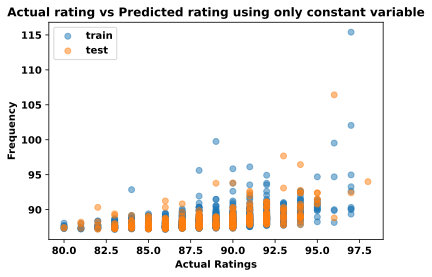

In [115]:
train_x2 = train_x[["Price($)","constant"]]
test_x2 = test_x[["Price($)","constant"]]

lr = linear_model.LinearRegression()
lr.fit(train_x2, train_y)

print("R^2 score from training set: {}".format(lr.score(train_x2,train_y)))
print("R^2 score from test set: {}".format(lr.score(test_x2,test_y)))

print("\nCoefficient of the prediction")
for feat, coef in zip(train_x2.columns, lr.coef_):
    print("feature {}".format(feat)+" : "+str(coef))
print("Bias/Intercept of the model prediction: ", lr.intercept_)

plt.scatter(train_y, lr.predict(train_x2), label = "train", alpha = 0.5);
plt.scatter(test_y, lr.predict(test_x2), label = "test", alpha = 0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Frequency")
plt.legend()
plt.title("Actual rating vs Predicted rating using only constant variable");

By adding a continuous feature (Price) along with the constants, the model predicted the rating better.

Also, model predicts that as the value of price increases, the rating of the wine increases also in a different scale.

Similar to model earlier, the coefficient of constant variable is 0 while the numerical value has some positive coefficient.

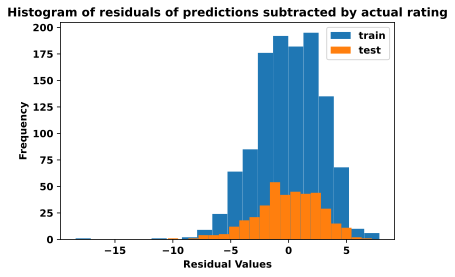

In [116]:
res1 = train_y- lr.predict(train_x2)
res2 = test_y- lr.predict(test_x2)

plt.hist(res1, bins=20, label="train");
plt.hist(res2, bins=20, label = "test")
plt.xlabel("Residual Values");
plt.ylabel("Frequency");
plt.legend()
plt.title("Histogram of residuals of predictions subtracted by actual rating");

# Challenge 3
### Repeat challenge 2 but with adding 1 categorical feature

R^2 score of train set: 0.23491605674828228
R^2 score of test set: 0.2637907949692265
Coefficient of the feature Price($) : 0.045464113930667016
Coefficient of the feature constant : -8.326672684688674e-17
Coefficient of the feature category_Dessert : 0.4386736093808147
Coefficient of the feature category_Port/Sherry : 1.7604304077568045
Coefficient of the feature category_Red : -0.4325482769787069
Coefficient of the feature category_Rose : -1.6919030766059353
Coefficient of the feature category_Sparkling : 0.1411309642043627
Coefficient of the feature category_White : -0.21578362775734042
[ 4.54641139e-02 -8.32667268e-17  4.38673609e-01  1.76043041e+00
 -4.32548277e-01 -1.69190308e+00  1.41130964e-01 -2.15783628e-01]
Bias/Intercept of the model: 87.26935273534362


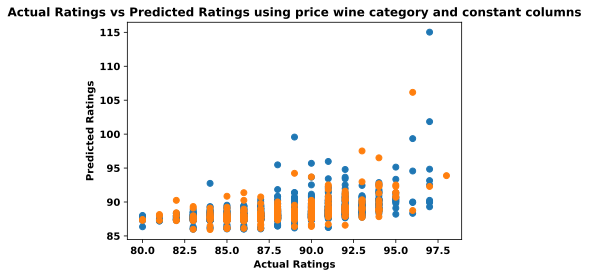

In [117]:
# add one a categorical feature to the previous model
train_x3 = train_x[["Price($)","Category","constant"]]
test_x3 = test_x[["Price($)","Category","constant"]]

# Before fitting the model, apply One Hot Encoding to the categorical feature
dummy_train_x3 = pd.get_dummies(train_x3,prefix="category", columns=["Category"])
dummy_test_x3 = pd.get_dummies(test_x3,prefix="category", columns=["Category"])

dummy_cols = dummy_train_x3.columns
lr = linear_model.LinearRegression()
lr.fit(dummy_train_x3, train_y)
print("R^2 score of train set: "+str(lr.score(dummy_train_x3, train_y)))
print("R^2 score of test set: "+str(lr.score(dummy_test_x3, test_y)))
for x in ["Coefficient of the feature {} : {}".format(col,coef) for col,coef in zip(dummy_cols, lr.coef_)]:
    print(x)
print(lr.coef_)
print("Bias/Intercept of the model: "+str(lr.intercept_))

plt.scatter(train_y,lr.predict(dummy_train_x3), label="train");
plt.scatter(test_y, lr.predict(dummy_test_x3), label = "test")
plt.xlabel("Actual Ratings");
plt.ylabel("Predicted Ratings");
plt.title("Actual Ratings vs Predicted Ratings using price wine category and constant columns");

R^2 score of train set: 0.2349160567482824
R^2 score of test set: 0.26379079496922675
Coefficient of the feature Price($) : 0.045464113930667
Coefficient of the feature constant : 3.885780586188048e-16
Coefficient of the feature category_Port/Sherry : 1.32175679837599
Coefficient of the feature category_Red : -0.87122188635952
Coefficient of the feature category_Rose : -2.13057668598675
Coefficient of the feature category_Sparkling : -0.2975426451764433
Coefficient of the feature category_White : -0.6544572371381535
[ 4.54641139e-02  3.88578059e-16  1.32175680e+00 -8.71221886e-01
 -2.13057669e+00 -2.97542645e-01 -6.54457237e-01]
Bias/Intercept of the model: 87.70802634472443


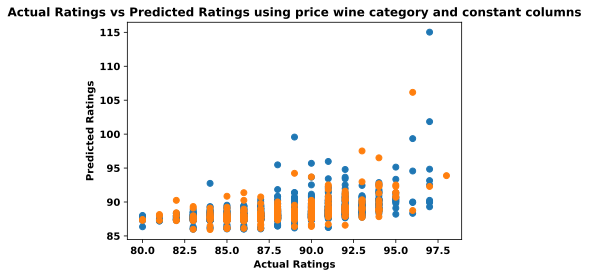

In [118]:
# add one a categorical feature to the previous model
train_x3 = train_x[["Price($)","Category","constant"]]
test_x3 = test_x[["Price($)","Category","constant"]]

# Before fitting the model, apply One Hot Encoding to the categorical feature
dummy_train_x3 = pd.get_dummies(train_x3,prefix="category", columns=["Category"], drop_first=True)
dummy_test_x3 = pd.get_dummies(test_x3,prefix="category", columns=["Category"], drop_first=True)

dummy_cols = dummy_train_x3.columns
lr = linear_model.LinearRegression()
lr.fit(dummy_train_x3, train_y)
print("R^2 score of train set: "+str(lr.score(dummy_train_x3, train_y)))
print("R^2 score of test set: "+str(lr.score(dummy_test_x3, test_y)))
for x in ["Coefficient of the feature {} : {}".format(col,coef) for col,coef in zip(dummy_cols, lr.coef_)]:
    print(x)
    
print(lr.coef_)
print("Bias/Intercept of the model: "+str(lr.intercept_))

plt.scatter(train_y,lr.predict(dummy_train_x3), label="train");
plt.scatter(test_y, lr.predict(dummy_test_x3), label = "test")
plt.xlabel("Actual Ratings");
plt.ylabel("Predicted Ratings");
plt.title("Actual Ratings vs Predicted Ratings using price wine category and constant columns");

Tried 2 differnt methods of getting dummy data frames. One did not drop the first column when generating a dummy data frame while the other one dropped the first column whlie generating model.

Both models had similar R^2 value around 0.244 while the model using first column dropped had a very minute decrease in R^2 value. Also for both models, the R^2 score for test set was .231 which is slightly worse than training set.

In general, the model shows that as the price of the wine increases the rating of the wine will also have some increase in rating, along with Port/Sherry and Sparkling wines tend to have better ratings.

# Challenge 4
### Enhance model by adding more features or transforming them

In [119]:
feature_cols = ["Price($)","Alcohol(%)","Bottle Size(ml)","vintage","constant"]

category_ohe = preprocessing.OneHotEncoder(handle_unknown="error", sparse=False, drop = "first")
countries_ohe = preprocessing.OneHotEncoder(handle_unknown="error", sparse=False, drop= "first")

train_x_category = category_ohe.fit_transform(train_x[["Category"]])
train_x_countries = countries_ohe.fit_transform(train_x[["Countries"]])

# make df using the outcome of the encoder
train_x_cat_df = pd.DataFrame(train_x_category, columns=category_ohe.get_feature_names(["category"]))
train_x_countries_df = pd.DataFrame(train_x_countries, columns=countries_ohe.get_feature_names(["countries"]))

# transform the categorical columns in test set also
test_x_category = category_ohe.transform(test_x[["Category"]])
test_x_countries = countries_ohe.transform(test_x[["Countries"]])

# Also make the df using the transformation
test_x_cat_df = pd.DataFrame(test_x_category, columns=category_ohe.get_feature_names(["category"]))
test_x_countries_df = pd.DataFrame(test_x_countries, columns=countries_ohe.get_feature_names(["countries"]))

ohe_train_x_df = pd.concat([train_x[feature_cols].reset_index(drop=True),
                        train_x_cat_df,
                        train_x_countries_df], axis=1)

ohe_test_x_df = pd.concat([test_x[feature_cols].reset_index(drop=True),
                        test_x_cat_df,
                        test_x_countries_df], axis=1)

In [120]:
print(ohe_train_x_df.shape, ohe_test_x_df.shape)

(1150, 30) (384, 30)


In [121]:
def print_model_info(model, x_train, y_train, x_test, y_test):
    """Prints R^2 score and coefficients for both train and test set"""
    
    print("R^2 score for train set: {}".format(model.score(x_train, y_train)))
    print("R^2 score for test set: {}".format(model.score(x_test, y_test)))

    print(model.coef_)
    print(model.intercept_)

(1150, 30) (384, 30)
R^2 score for train set: 0.3455641111315541
R^2 score for test set: 0.35952820016047293
[ 1.27689493e+00  4.57693990e-01 -9.41031451e-02  7.54449090e-01
 -2.52902129e+13 -5.67905757e-02 -2.98061400e-02 -3.24967592e-01
  1.95637606e-01 -3.93814181e-02  2.78168083e-01  4.80487529e-01
 -1.93485063e-02 -1.30640234e-01  1.83734531e-01 -5.57917874e-02
  5.66141345e-01  3.78984710e-01 -2.03706311e-03  2.03409117e-01
  9.95683072e-02  4.00279149e-01  1.74144525e-01  3.26986055e-01
 -4.18826270e-02  6.37445958e-02  1.02968230e-01 -1.11030106e-01
  4.57815001e-01 -7.89790349e-02]
88.4695652173913


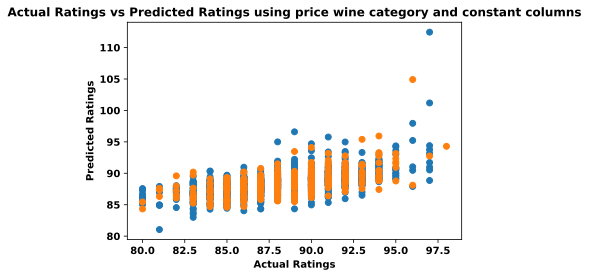

In [27]:
# Standard Scaling features 
ss = preprocessing.StandardScaler()
ss.fit(ohe_train_x_df)
scaled_ohe_train_x = ss.transform(ohe_train_x_df)
scaled_ohe_test_x = ss.transform(ohe_test_x_df)

print(scaled_ohe_train_x.shape, scaled_ohe_test_x.shape)

lr = linear_model.LinearRegression()
lr.fit(scaled_ohe_train_x, train_y)
print_model_info(lr, scaled_ohe_train_x, train_y,scaled_ohe_test_x, test_y)

plt.scatter(train_y,lr.predict(scaled_ohe_train_x), label="train");
plt.scatter(test_y, lr.predict(scaled_ohe_test_x), label = "test")
plt.xlabel("Actual Ratings");
plt.ylabel("Predicted Ratings");
plt.title("Actual Ratings vs Predicted Ratings using price wine category and constant columns");

### add column with log(price)

In [122]:
# since there seemed to be some relationship between price and the rating 
train_x["log_price"] = np.log(train_x["Price($)"])
train_x["log2_price"] = np.log2(train_x["Price($)"])
train_x["log10_price"] = np.log10(train_x["Price($)"])

test_x["log_price"] = np.log(test_x["Price($)"])
test_x["log2_price"] = np.log2(test_x["Price($)"])
test_x["log10_price"] = np.log10(test_x["Price($)"])


In [123]:
train_x.head()

,Price($),Alcohol(%),Bottle Size(ml),Category,vintage,Countries,age,constant,log_price,log2_price,log10_price
0,28.0,14.9,750.0,Red,2009.0,US,12.0,1,3.332205,4.807355,1.447158
1,17.0,12.0,750.0,Rose,2009.0,US,12.0,1,2.833213,4.087463,1.230449
2,25.0,14.0,750.0,White,2014.0,Italy,7.0,1,3.218876,4.643856,1.397940
3,27.0,12.5,750.0,White,2015.0,France,6.0,1,3.295837,4.754888,1.431364
4,11.0,13.5,750.0,Red,2008.0,US,13.0,1,2.397895,3.459432,1.041393


In [124]:
test_x.head()

,Price($),Alcohol(%),Bottle Size(ml),Category,vintage,Countries,age,constant,log_price,log2_price,log10_price
0,15.0,13.5,750.0,Red,2015.0,France,6.0,1,2.708050,3.906891,1.176091
1,24.0,12.5,750.0,White,2014.0,Israel,7.0,1,3.178054,4.584963,1.380211
2,26.0,13.0,750.0,Red,1997.0,Italy,24.0,1,3.258097,4.700440,1.414973
3,8.0,12.5,750.0,White,2003.0,France,18.0,1,2.079442,3.000000,0.903090
4,60.0,13.0,750.0,White,2018.0,France,3.0,1,4.094345,5.906891,1.778151


In [127]:
feats = ["Price($)","Alcohol(%)","Bottle Size(ml)", "vintage","age"]
log_price = ["log_price"]
log2_price = ["log2_price"]
log10_price = ["log10_price"]
log_price_list = [log_price,log2_price, log10_price]


# fitting models to use only one type of logged price to see the 
for log_p in log_price_list:
    print(log_p)
    lr = linear_model.LinearRegression()
    lr.fit(train_x[feats+log_p], train_y)
    print_model_info(lr, train_x[feats+log_p], train_y, test_x[feats+log_p], test_y)
    print("\n")

['log_price']
R^2 score for train set: 0.4229772947629765
R^2 score for test set: 0.45579190698728433
[-8.29655511e-03 -5.11171782e-02 -1.32250811e-03  2.69289920e+10
  2.69289920e+10  3.36880986e+00]
-54423492761584.04


['log2_price']
R^2 score for train set: 0.4230038266347431
R^2 score for test set: 0.4559434279866259
[-8.29655511e-03 -5.10898437e-02 -1.32214749e-03  2.69289770e+10
  2.69289770e+10  2.33506794e+00]
-54423462564231.86


['log10_price']
R^2 score for train set: 0.42300791783211145
R^2 score for test set: 0.45579009394198644
[-8.29655511e-03 -5.11060208e-02 -1.32186803e-03  2.69290082e+10
  2.69290082e+10  7.75696037e+00]
-54423525570163.02




In [128]:
def standard_scale_converter(x_train, x_test, 
                             numerical_cols = ["Price($)","Alcohol(%)","Bottle Size(ml)",
                                               "vintage","log_price","log2_price","log10_price","age"],
                             cat_cols = ["Countries","Category"]
                            ):
    
    """takes in train_x and test_x and scale numerical variables"""
    ss = preprocessing.StandardScaler()
    ss_train_x = ss.fit_transform(x_train[numerical_cols])
    ss_test_x = ss.transform(x_test[numerical_cols])
    scaled_train = pd.DataFrame(ss_train_x, columns = numerical_cols)
    scaled_train = pd.concat([scaled_train.reset_index(drop=True),
                            x_train[cat_cols]], axis=1)
    
    scaled_test = pd.DataFrame(ss_test_x, columns = numerical_cols)
    scaled_test = pd.concat([scaled_test.reset_index(drop=True),
                            x_test[cat_cols]], axis=1)
    return scaled_train, scaled_test

In [129]:

def country_category_ohe_converter(x_train, x_test, non_cat = numerical_cols):
    """takes in train and test_X and apply one hot encoding to categorical variables"""
    cat_ohe = preprocessing.OneHotEncoder(handle_unknown="error", sparse = False, drop="first")
    country_ohe = preprocessing.OneHotEncoder(handle_unknown="error", sparse = False, drop="first")

    # one hot encode category and countries columns
    train_cat = cat_ohe.fit_transform(x_train[["Category"]])
    train_countries = country_ohe.fit_transform(x_train[["Countries"]])

    # convert to df
    train_cat_df = pd.DataFrame(train_cat, columns=cat_ohe.get_feature_names(["category"]))
    train_countries_df = pd.DataFrame(train_countries, columns=country_ohe.get_feature_names(["countries"]))
    
    # do the same for test
    test_cat = cat_ohe.transform(x_test[["Category"]])
    test_countries = countries_ohe.transform(x_test[["Countries"]])
    
    # conver to df
    test_cat_df = pd.DataFrame(test_cat, columns= cat_ohe.get_feature_names(["category"]))
    test_countries_df = pd.DataFrame(test_countries, columns= country_ohe.get_feature_names(["countries"]))
    
    ohe_train_x_df = pd.concat([x_train[non_cat].reset_index(drop=True),
                               train_cat_df,
                               train_countries_df], axis = 1)
    ohe_test_x_df = pd.concat([x_test[non_cat].reset_index(drop=True),
                               test_cat_df,
                               test_countries_df], axis = 1)
    return ohe_train_x_df, ohe_test_x_df

In [130]:
def polyfeat_converter(train_data,test_data,featuers, degree= 2, interaction_bool = True):
    poly = preprocessing.PolynomialFeatures(degree= degree, interaction_only=interaction_bool)
    train_poly_feat_outcomes = poly.fit_transform(train_data[featuers])
    
    train_target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(featuers,p) for p in poly.powers_]]
    train_output_df = pd.DataFrame(train_poly_feat_outcomes, columns = train_target_feature_names)
    
    
    # do the same for test
    test_poly_feat_outcomes=poly.transform(test_data[featuers])
    test_target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(featuers,p) for p in poly.powers_]]
    test_output_df = pd.DataFrame(test_poly_feat_outcomes, columns = test_target_feature_names)
    
    
    return train_output_df, test_output_df

In [135]:
numerical_cols = ["Price($)", "Alcohol(%)","Bottle Size(ml)", "vintage","age","log_price","log2_price", "log10_price"]
categorical_cols = ["Category","Countries"]
scaled_train, scaled_test = standard_scale_converter(train_x, test_x)
print(train_x.shape, test_x.shape)
print(scaled_train.shape,scaled_test.shape)

(1150, 11) (384, 11)
(1150, 10) (384, 10)


In [48]:
# adding poly nomial features to the dataset
features = scaled_ohe_train.columns
poly_scaled_ohe_train,poly_scaled_ohe_test = polyfeat_converter(scaled_ohe_train, scaled_ohe_test, featuers=features)
print(poly_scaled_ohe_train.shape,poly_scaled_ohe_test.shape)

(1150, 529) (384, 529)


In [52]:
# using lasso for feature extraction within 
lasso = linear_model.LassoCV(n_jobs=-2, random_state=789, cv=5, max_iter=5000)
reg = lasso.fit(poly_scaled_ohe_train, train_y)

print_model_info(reg, poly_scaled_ohe_train, train_y, poly_scaled_ohe_test, test_y)

R^2 score for train set: 0.46804641993859675
R^2 score for test set: 0.4450046456255011
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.14100751e-01
  5.18777724e-01  1.96421134e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -3.03521892e-02  0.00000000e+00
  0.00000000e+00  4.80765201e-02  6.21357340e-01 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.69139473e-01
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  8.28681360e-01 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.68298639e-01 -7.54269898e-02
 -0.00000000e+00 -4.63631510e-02  0.00000000e+00 -0.00000000e+00
 -7.40084532e-02 -1.64300615e-16 -1.74531789e-17  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -4.03117825e-02  2.03989972e-01 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  

In [57]:
# printing out what features are meaningful in predicting wine rating
[":  ".join([col,str(coef)]) for col,coef in zip(poly_scaled_ohe_train.columns,reg.coef_)]

[':  0.0',
 'Price($)^1:  0.0',
 'Alcohol(%)^1:  0.0',
 'Bottle Size(ml)^1:  -0.11410075088332482',
 'vintage^1:  0.518777723841307',
 'log_price^1:  1.9642113397145946',
 'log2_price^1:  0.0',
 'log10_price^1:  0.0',
 'category_Port/Sherry^1:  0.0',
 'category_Red^1:  -0.0',
 'category_Rose^1:  -0.030352189192552313',
 'category_Sparkling^1:  0.0',
 'category_White^1:  0.0',
 'countries_Australia^1:  0.04807652010237153',
 'countries_Austria^1:  0.6213573404322215',
 'countries_Bosnia and Herzegovina^1:  -0.0',
 'countries_Bulgaria^1:  -0.0',
 'countries_Canada^1:  0.0',
 'countries_Chile^1:  -0.0',
 'countries_France^1:  0.2691394725509045',
 'countries_Germany^1:  0.0',
 'countries_Greece^1:  -0.0',
 'countries_Hungary^1:  0.0',
 'countries_Israel^1:  0.0',
 'countries_Italy^1:  -0.0',
 'countries_New Zealand^1:  -0.0',
 'countries_Portugal^1:  0.8286813596597498',
 'countries_Romania^1:  -0.0',
 'countries_Slovenia^1:  0.0',
 'countries_South Africa^1:  0.0',
 'countries_Spain^1:  

In [71]:
lasso_coef_df = pd.DataFrame([[col,coef] for col,coef in zip(poly_scaled_ohe_train.columns,reg.coef_) if coef != 0.0]).sort_values(1, ascending=False)
lasso_coef_df.head()

In [68]:
# 
uniques = set()
for l in lasso_coef_df[0].apply(lambda x: x.split("x")).values:
    for x in l:
        uniques.add(x)

In [77]:
clean_uniques = [x.replace("^1","") for x in list(uniques)]

In [78]:
# model 1
# using lasso_coef_df, use the columns that are in column 0 from poly_scaled_ohe_train/test
cols_touse = lasso_coef_df[0].values
lr = linear_model.LinearRegression()
lr.fit(poly_scaled_ohe_train[cols_touse], train_y)
print_model_info(lr, poly_scaled_ohe_train[cols_touse], train_y, poly_scaled_ohe_test[cols_touse], test_y)
print("\n\n")


# model 2
# using lasso_coef_df, use the uniques from poly_scaled_ohe_train/test
cols_touse = list(uniques)
lr = linear_model.LinearRegression()
lr.fit(poly_scaled_ohe_train[cols_touse], train_y)
print_model_info(lr, poly_scaled_ohe_train[cols_touse], train_y, poly_scaled_ohe_test[cols_touse], test_y)
print("\n\n")


# model3
# using uniques fit scaled_ohe_train/test
cols_touse = list(uniques)
lr = linear_model.LinearRegression()
lr.fit(scaled_ohe_train[clean_uniques], train_y)
print_model_info(lr, scaled_ohe_train[clean_uniques], train_y, scaled_ohe_test[clean_uniques], test_y)

R^2 score for train set: 0.47970097576661386
R^2 score for test set: 0.41337885417947706
[ 1.91919470e+00  1.41901704e+00  1.02953596e+00  1.00073214e+00
  5.30338675e-01  8.72361492e-01  6.63847463e-01  7.23932441e-01
  3.94591050e-01  7.23420311e-01  2.10440799e-01  2.31355259e-01
  6.93103344e-01  2.33621880e-01  3.04563898e-01  4.58476146e+11
  9.88420024e-02  7.01468260e-01  4.82072511e-02  3.24826024e-02
  7.28637480e+11 -1.18711363e+12 -7.90200955e-03  3.78497122e+12
 -3.12148831e+12  2.63922463e+11 -1.19853359e+12 -1.48934539e-02
 -1.66856162e-01  5.65631324e-02  3.88581844e+11 -4.26341481e-01
 -3.29092023e-01 -2.16327181e-01 -2.63922463e+11 -2.26982633e-01
 -6.63482901e+11  2.27225749e-01 -1.36087395e-01 -5.23227591e-01
 -1.46951430e-01 -3.90924779e-01 -2.74962733e-01 -4.85697381e-01
  8.09951744e+11 -5.89468744e-01 -9.60408914e-01]
88.3694675611413



R^2 score for train set: 0.4558241252847608
R^2 score for test set: 0.4487113125617106
[ 0.65735246  0.11019263  0.72661322  3

In [137]:
# try poly features from scaled_ohe_train/test
# using 1 log_price type only
numerical_cols
categorical_cols
for log in numerical_cols[5:]:
    poly_train, poly_test, = polyfeat_converter(scaled_ohe_train, scaled_ohe_test, numerical_cols[:4]+[log])
    lasso = linear_model.LassoCV(n_jobs=-2, random_state=789, cv=5, max_iter=5000)
    reg = lasso.fit(poly_train, train_y)
    print_model_info(reg, poly_train, train_y, poly_test, test_y)
    print("\n")
    


R^2 score for train set: 0.4213923657797227
R^2 score for test set: 0.45416512457542413
[ 0.          0.         -0.         -0.          0.58065396  1.90007776
 -0.          0.         -0.         -0.03214294  0.01093205 -0.
 -0.00354083 -0.          0.         -0.        ]
88.4955138112491


R^2 score for train set: 0.4213923657797227
R^2 score for test set: 0.45416512457542413
[ 0.          0.         -0.         -0.          0.58065396  1.90007776
 -0.          0.         -0.         -0.03214294  0.01093205 -0.
 -0.00354083 -0.          0.         -0.        ]
88.4955138112491


R^2 score for train set: 0.4213923657797227
R^2 score for test set: 0.45416512457542424
[ 0.          0.         -0.         -0.          0.58065396  1.90007776
 -0.          0.         -0.         -0.03214294  0.01093205 -0.
 -0.00354083 -0.          0.         -0.        ]
88.4955138112491




# Add one more column 'age'

In [138]:
train_x.head()

,Price($),Alcohol(%),Bottle Size(ml),Category,vintage,Countries,age,constant,log_price,log2_price,log10_price
0,28.0,14.9,750.0,Red,2009.0,US,12.0,1,3.332205,4.807355,1.447158
1,17.0,12.0,750.0,Rose,2009.0,US,12.0,1,2.833213,4.087463,1.230449
2,25.0,14.0,750.0,White,2014.0,Italy,7.0,1,3.218876,4.643856,1.397940
3,27.0,12.5,750.0,White,2015.0,France,6.0,1,3.295837,4.754888,1.431364
4,11.0,13.5,750.0,Red,2008.0,US,13.0,1,2.397895,3.459432,1.041393


In [164]:
numerical_cols
cat_feats
# scaling numerical variables
ss_train, ss_test = standard_scale_converter(train_x[numerical_cols+cat_feats], test_x[numerical_cols+cat_feats],
                                             numerical_cols=numerical_cols,
                                            cat_cols= cat_feats)

In [165]:
# one hot encode categorical variables
ohe_ss_train, ohe_ss_test = country_category_ohe_converter(ss_train,ss_test, non_cat=numerical_cols )

In [166]:
# include polynomial features
poly_ohe_ss_train,poly_ohe_ss_test=polyfeat_converter(ohe_ss_train, ohe_ss_test, 
                                                      list(ohe_ss_train.columns),interaction_bool=True)

In [167]:
# feature extraction using Lasso 
lasso = linear_model.LassoCV(n_jobs=-2, random_state=789, cv=5, max_iter=5000)
reg = lasso.fit(poly_ohe_ss_train,train_y)
print_model_info(reg, poly_ohe_ss_train, train_y, poly_ohe_ss_test, test_y)

R^2 score for train set: 0.4740403623975803
R^2 score for test set: 0.4115433708568079
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.27431435e-01
  6.30017003e-01 -2.29350838e-14  1.95787164e+00  3.89253847e-16
  1.85358975e-17  0.00000000e+00 -0.00000000e+00 -1.07582973e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.45134023e-01
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  2.01681863e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  8.14346908e-01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.46310810e-01
 -7.48622117e-02 -0.00000000e+00 -4.65201257e-02  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -6.12518273e-02 -6.83081310e-17
 -6.01833754e-17  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -5.72639969e-02
  1.54305976e-01 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0

In [168]:
# creating df with features and their coefficient values
lasso_coef_df = pd.DataFrame([[col,coef] for col,coef in zip(poly_scaled_ohe_train.columns,reg.coef_) if coef != 0.0]).sort_values(1, ascending=False)

In [169]:
# sorting from highest coefficient to lowest
lasso_coef_df.sort_values(1, ascending=False)

,0,1
3,log2_price^1,1.957872e+00
9,countries_Romania^1,8.143469e-01
7,countries_Bosnia and Herzegovina^1,6.451340e-01
1,vintage^1,6.300170e-01
49,countries_Austria^1xcountries_Bosnia and Herze...,6.261046e-01
27,Bottle Size(ml)^1xvintage^1,3.768903e-01
25,Alcohol(%)^1xcountries_Hungary^1,3.583762e-01
31,vintage^1xlog10_price^1,3.006831e-01
35,vintage^1xcountries_France^1,2.137293e-01
8,countries_Germany^1,2.016819e-01


In [219]:
# using extracted features, fit it to linear regression model
lr = linear_model.LinearRegression()
lr.fit(poly_ohe_ss_train[lasso_coef_df[0]], train_y)
print_model_info(lr, poly_ohe_ss_train[lasso_coef_df[0]], train_y, poly_ohe_ss_test[lasso_coef_df[0]], test_y)

R^2 score for train set: 0.4538647435864638
R^2 score for test set: 0.42674067608123734
[ 7.17695444e-01 -1.28964668e+00 -7.30888147e-01  3.81440957e-01
  2.88311042e-14  1.35050319e-01 -2.31682665e+00  2.10492376e-02
  2.57354384e-01 -6.57243471e-02 -3.48307871e-01  2.68441403e+00
 -9.60342916e-15  1.32189580e+00  5.05837760e-01 -1.28702336e-02
  8.90054431e-01 -1.93910853e-01 -3.73610355e+00  1.02140518e-14
  4.53506088e-01  2.66453526e-15 -4.53358486e-01  7.17695444e-01
  3.25019623e-02 -1.43299234e-01 -4.89507024e-01  3.75880484e+00
  7.17695444e-01  4.79029721e-01  0.00000000e+00 -5.73291102e+00
 -8.88178420e-16 -3.22176006e+00 -4.71983702e-04  8.48131698e-01
 -4.79473475e-03  7.36683008e+00  3.42916591e-01  6.10326961e-02
 -5.40278414e-01  1.41129300e-01  1.86004697e-01  1.11656313e+00
  1.19253729e-02  1.46359882e+01  4.34639952e-01  1.71213265e-01
  2.84586262e-01  0.00000000e+00 -2.89242972e-01]
88.75178957260859


In [225]:
# listing features and their coefficients from largest to lowest
pd.DataFrame([[i,j] for i,j in zip(poly_ohe_ss_train[lasso_coef_df[0]].columns,lr.coef_)]).sort_values(1, ascending=False)

,0,1
45,Bottle Size(ml)^1xcountries_Portugal^1,1.463599e+01
37,Price($)^1xcountries_Germany^1,7.366830e+00
27,Price($)^1xcategory_Port/Sherry^1,3.758805e+00
11,Price($)^1xcountries_Greece^1,2.684414e+00
13,vintage^1xcountries_Austria^1,1.321896e+00
43,category_Sparkling^1,1.116563e+00
16,Alcohol(%)^1xcategory_Sparkling^1,8.900544e-01
35,log10_price^1xcountries_Uruguay^1,8.481317e-01
23,log10_price^1,7.176954e-01
0,log2_price^1,7.176954e-01


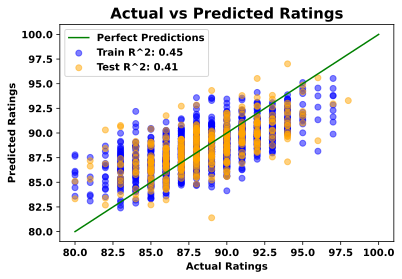

In [213]:
# plotting the train and test predictions compared to actual rating score
plt.scatter(train_y, lr.predict(poly_ohe_ss_train[lasso_coef_df[0]]), c = "blue",alpha=0.5, label = "Train R^2: 0.45")
plt.scatter(test_y, lr.predict(poly_ohe_ss_test[lasso_coef_df[0]]), c = "orange", alpha=0.5,label = "Test R^2: 0.41")
plt.plot(np.linspace(80,100,100),np.linspace(80,100,100), c="green", label="Perfect Predictions");
plt.xlabel("Actual Ratings");
plt.ylabel("Predicted Ratings");
plt.title("Actual vs Predicted Ratings", fontsize = 15);
plt.legend();
plt.savefig("data/Rating predictions.png", dpi = 300)


In [ ]:
plt.scatter(test_y, lr.predict(poly_ohe_ss_test[lasso_coef_df[0]]), c= "orange")
plt.plot(np.linspace(80,100,100),np.linspace(80,100,100), c = "b")
plt.xlabel("Actual Ratings");
plt.ylabel("Predicted Ratings");
plt.title("Actual vs Predicted Ratings", fontsize = 15);
plt.savefig("data/Rating predictions.png", dpi = 300)

C:\Users\yahoy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yahoy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yahoy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

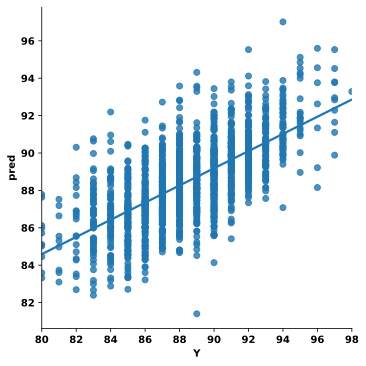

In [196]:
new_trainx = poly_ohe_ss_train[lasso_coef_df[0]]
new_trainx["pred"] = lr.predict(new_trainx)
new_trainx["Y"] = train_y

new_testx = poly_ohe_ss_test[lasso_coef_df[0]]
new_testx["pred"] = lr.predict(new_testx)
new_testx["Y"] = test_y

train_test_x = pd.concat([new_trainx, new_testx])

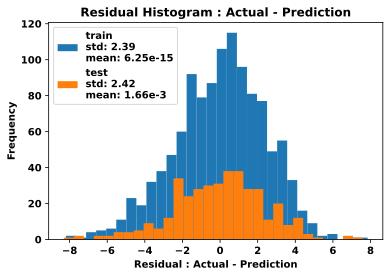

In [218]:
# plotting residual histogram of actual rating subtracted by predicted
plt.hist(train_y - new_trainx["pred"], bins=30, label="train\nstd: 2.39 \nmean: 6.25e-15");
plt.hist(test_y - new_testx["pred"], bins=30, label="test\nstd: 2.42 \nmean: 1.66e-3");
plt.title("Residual Histogram : Actual - Prediction");
plt.xlabel("Residual : Actual - Prediction");
plt.ylabel("Frequency");
plt.legend()
plt.savefig("data/residual_hist.png", dpi=300)

In [206]:
np.std((test_y-new_testx["pred"]).to_list()+(train_y-new_trainx["pred"]).to_list())

2.3985119651115414

In [217]:
np.mean(test_y-new_testx["pred"])

-0.0016625474544654424

In [200]:
print(np.mean(train_y-new_trainx["pred"]),np.std(train_y-new_trainx["pred"]))

6.252776074688882e-15 2.3896457392945445
